# This report will analyze the daily energy use of households on the Abar photovoltaic microgrid.

In [1]:
#loading libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

## We start with an aggregated csv file for each household containing energy data (kWh) per 15 minute time intervals.

In [2]:
data = pd.read_csv('../Data/aggregated_PV_data.csv', parse_dates = True, index_col = 0)
data.head()

,111,112,113,114,121,122,123,124,131,132,...,203,204,221,222,223,224,231,232,233,234
DT,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,...,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.0
2016-01-01 00:15:00,0.003,0.005,0.004,0.004,0.004,0.003,0.008,0.0,0.008,0.008,...,0.0,0.0,0.003,0.004,0.0,0.0,0.004,0.008,0.006,0.0
2016-01-01 00:30:00,0.006,0.010,0.007,0.008,0.009,0.005,0.016,0.0,0.016,0.015,...,0.0,0.0,0.006,0.007,0.0,0.0,0.007,0.016,0.009,0.0
2016-01-01 00:45:00,0.009,0.015,0.007,0.012,0.014,0.007,0.022,0.0,0.024,0.023,...,0.0,0.0,0.010,0.011,0.0,0.0,0.010,0.024,0.012,0.0
2016-01-01 01:00:00,0.011,0.020,0.007,0.016,0.019,0.007,0.029,0.0,0.032,0.030,...,0.0,0.0,0.013,0.015,0.0,0.0,0.013,0.032,0.015,0.0


## We create an empty list `daily`, accumulator and iterator variables that  will keep track of the daily energy for each iteration of the loop. We will start by analyzing one household `111` and take the difference between each 15 minute interval to get the power. 

In [3]:
daily = []
total_energy = 0
daily_energy_1 = 0
day_iterator = 1
month_iterator = 1
household = '111'
df = data[household].diff()
df = df.reset_index()

## The loop begins with treating null values as 0 and then calculates energy for each 15 minute interval where power (kW / 15min) * time (4 - 15 min intervals per hour) = energy (kWh). Each 15 minute energy calculation is added to `total_energy`. We use `if` statements to determine when the timestamp reaches the end of a 24 hour period and add that daily calculation to our `daily` list. After each addition to `daily` we create a DataFrame `household_daily_energy`, advance the day by one and continue the loop. Since each month has a different number of days we write `if/elif` statements at the end of the loop to handle the end of each month i.e. there are only 3 cases and since Feb was a leap year (31,30, or 29) if day iterator reaches 32 (which analyzes 31 days) the month iterator is advanced by one, day iterator restarts at one, and the loop is continued. The end result should be a year of daily energy calculations for household `111`.

In [4]:
for i in range(len(df)):
    # replacing null values with zero
    if np.isnan(df[household][i]) == True:
        df[household][i] = 0
    power = df[household][i]
    time = 4
    energy = power * time #kWh
    # total_energy builds from energy calc
    total_energy += energy
    # day and month variables converted to strings
    day = str(day_iterator).zfill(2)
    month = str(month_iterator).zfill(2)
    # action to perfrom when timestamp reaches midnight of each day also iterates over each month    
    if str(df['DT'][i]) == "2016-" + month + "-" + day + " 00:00:00":
        total_energy = total_energy - daily_energy_1
        daily_energy_1 = total_energy
        day_iterator += 1
        daily.append(total_energy)        
        household_daily_energy = pd.DataFrame(daily, columns=[household + 'daily_energy']) 
            
        if day_iterator == 32:
            month_iterator += 1
            day_iterator = 1
        elif day_iterator == 31:
            month_iterator += 1
            day_iterator = 1
        elif day_iterator == 30:
            month_iterator += 1
            day_iterator = 1

/projects/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Each daily energy calculation is observed:

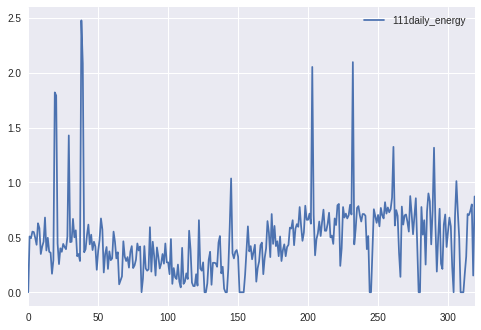

In [5]:
household_daily_energy.plot()

## As a distribution:
### Relatively even distribution with a few outliers.

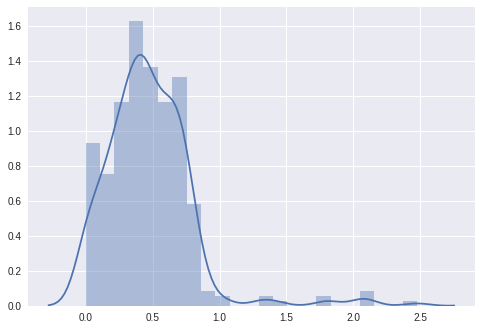

In [6]:
sns.distplot(household_daily_energy)

## Raw statistical data:
### Note: standard deviation.

In [7]:
household_daily_energy.describe()

,111daily_energy
count,320.000000
mean,0.473313
std,0.330742
min,0.000000
25%,0.271000
50%,0.436000
75%,0.644000
max,2.476000


## Review: As shown above the count is only 320 entries, so some data points are missing. It turns out that this method is not well suited to analyze each household so, the next step will be to use a `resample` function which is much more capable of handling this type of operation and will allow us to make daily energy calculations for each household in a more concise manner. The distribution could also be categorized by month, which may provide clues to yearly energy trends if any.